In [1]:
"""
Created on 2018年10月18日

@author: STEVEN.CY.CHUANG
"""

from time import time
import unittest
import numpy as np
import pickle
import keras
from sklearn.metrics import silhouette_score

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

from keras.datasets import mnist
from keras.metrics import binary_accuracy
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))

import sys  
sys.path.append("../")
from util.visualization import *
from util import import_notebook
from module.autoencoder import *

Using TensorFlow backend.


importing Jupyter notebook from ../module/autoencoder.ipynb


In [2]:
class TestAE(unittest.TestCase):
    
    num_epochs = 10
    size_batch = 512
    lay_den_enc = [32, 8]
    name_optim = "adam"
    path_temp_best = "../model/temp/"
    patience = 3
    
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype("float32") / 255.
    x_test = x_test.astype("float32") / 255.
    num_train = len(x_train)
    num_test = len(x_test)
    size_digit = x_train.shape[1:]

    dim_input = np.prod(x_train.shape[1:])
    x_train = x_train.reshape((num_train, dim_input))
    x_test = x_test.reshape((num_test, dim_input))
    print(x_train.shape)
    print(x_test.shape)
    
    def test_init(self):
        print("Test for AE:")
        print("Test for init:")
        ae = AE(self.dim_input, lay_den_enc=self.lay_den_enc)
        ae.encoder.summary()
        ae.decoder.summary()
        ae.autoencoder.summary()
        self.ae = ae
        print("\r\n")
        
        
    def test_specific_decode(self):
        print("Test for specificdecode:")
        ae = AE(self.dim_input, lay_den_enc=self.lay_den_enc, lay_den_dec=[1, 4, 16])
        ae.fit(self.x_train, self.x_test, 
               num_epochs=5,
               patience=1,
               size_batch=1024,
               metrics=["binary_accuracy"],
               path_temp_best=self.path_temp_best)
        ae.encoder.summary()
        ae.decoder.summary()
        ae.autoencoder.summary()
        print("\r\n")

        
    def test_fit(self):
        print("Test for fitting:")
        history, time_train = self.ae.fit(self.x_train, self.x_test, 
                                         num_epochs=self.num_epochs,
                                         size_batch=self.size_batch,
                                         path_temp_best=self.path_temp_best)
        print("\r\n")
        
        
    def test_fit_check_best(self):
        print("Test for checking best fit:")
        history, time_train = self.ae.fit(self.x_train, self.x_test, 
                                         num_epochs=20,
                                         patience=1,
                                         size_batch=self.size_batch,
                                         metrics=["binary_accuracy"],
                                         path_temp_best=self.path_temp_best)
        # print the binary accuracy of testing dataset for verifying best model
        print(tf.keras.backend.eval(binary_accuracy(self.x_test, self.ae.autoencoder.predict(self.x_test))).mean())
        print("\r\n")
    
    
    def test_fit_check_verbose(self):
        print("Test for verbose:")
        history, time_train = self.ae.fit(self.x_train, self.x_test, 
                                         num_epochs=self.num_epochs,
                                         size_batch=self.size_batch,
                                         path_temp_best=self.path_temp_best,
                                         verb=0)
        
        history, time_train = self.ae.fit(self.x_train, self.x_test, 
                                         num_epochs=self.num_epochs,
                                         size_batch=self.size_batch,
                                         path_temp_best=self.path_temp_best,
                                         verb=1)
        
        history, time_train = self.ae.fit(self.x_train, self.x_test, 
                                         num_epochs=self.num_epochs,
                                         size_batch=self.size_batch,
                                         path_temp_best=self.path_temp_best,
                                         verb=2)
        print("\r\n")
    
    
    def test_save_seperate(self):
        print("Test for saving seperately:")
        self.ae.encoder.save("../model/test/AE/encoder.h5")
        self.ae.decoder.save("../model/test/AE/decoder.h5")
        print("\r\n")

        
    def test_save(self):
        print("Test for saving:")
        self.ae.save("../model/test/AE/ae")
        print("\r\n")
                
            
    def test_load_seperate(self):
        print("Test for loading seperately:")
        encoder = keras.models.load_model("../model/test/AE/encoder.h5")
        decoder = keras.models.load_model("../model/test/AE/decoder.h5")
#         autoencoder = keras.models.load_model("./temp/autoencoder.h5", custom_objects={"lossae": lossae})
        encoder.summary()
        decoder.summary()
#         autoencoder.summary()
        encode_test = encoder.predict(self.x_test)
        decode_test = decoder.predict(encode_test)
#         decode_test2 = autoencoder.predict(self.x_test)

#         Plot the comparison of original and reconstructed pictures, and calculate the errors
        plot_comp_decode(self.x_test, decode_test, size_digit=self.size_digit)
        err = comp_reconst(self.x_test, decode_test)
        print(err)
        print("\r\n")
        
        
    def test_load(self):
        print("Test for loading:")
        encoder, decoder, autoencoder = load("../model/test/AE/ae")
        encoder.summary()
        decoder.summary()
        autoencoder.summary()
        encode_test = encoder.predict(self.x_test)
        decode_test = decoder.predict(encode_test)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plot_comp_decode(self.x_test, decode_test, size_digit=self.size_digit)
        err = comp_reconst(self.x_test, decode_test)
        print(err)
        print("\r\n")
        
    
    def test_prediction(self):
        print("Test for prediction:")
        # Set the initialization
        x_test = self.x_test
        y_test = self.y_test
        size_digit = self.size_digit
        ae = self.ae
        encoder = ae.encoder
        decoder = ae.decoder
        
        # Get encoded and decoded values
        encode_test = encoder.predict(x_test)
        decode_test = decoder.predict(encode_test)
        mean_enc_test = np.mean(encode_test, axis=0)
        std_enc_test = np.std(encode_test, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plot_comp_decode(x_test, decode_test, size_digit=size_digit)
        err = comp_reconst(x_test, decode_test)
        print(err)
        
        # Plot the scatter of the encoding space
        xlim = (mean_enc_test[0] - 4*std_enc_test[0], mean_enc_test[0] + 4*std_enc_test[0])
        ylim = (mean_enc_test[1] - 4*std_enc_test[1], mean_enc_test[1] + 4*std_enc_test[1])
        plot_scatter_encode(encode_test, y_test, xlim, ylim, num_show=10000)
        scoreSilh = silhouette_score(encode_test, y_test)    
        
        # Plot the decoding results from the encoding scatter
        plot_scatter_decode(decoder, size_digit, xlim, ylim)
        print("\r\n")

(60000, 784)
(10000, 784)


In [3]:
class TestConvAE(unittest.TestCase):
    
    num_epochs = 5
    size_batch = 512
    lay_den_enc = [8]
    lay_conv_enc = [4, 16]
    size_kernel = 3
    name_optim = "adam"
    path_temp_best = "../model/temp/"
    patience = 3
    
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype("float32") / 255.
    x_test = x_test.astype("float32") / 255.
    num_train = len(x_train)
    num_test = len(x_test)
    size_digit = x_train.shape[1:]
    dim_input = [*size_digit, 1]
    x_train = x_train.reshape((num_train, *dim_input))
    x_test = x_test.reshape((num_test, *dim_input))
    print(x_train.shape)
    print(x_test.shape)
    
    def test_init(self):
        print("Test for ConvAE:")
        print("Test for init:")
        conv_ae = ConvAE(self.dim_input, lay_den_enc=self.lay_den_enc, lay_conv_enc=self.lay_conv_enc)
        conv_ae.encoder.summary()
        conv_ae.decoder.summary()
        conv_ae.autoencoder.summary()
        self.conv_ae = conv_ae
        print("\r\n")
        
        
    def test_specific_decode(self):
        print("Test for specificdecode:")
        conv_ae = ConvAE(self.dim_input, lay_den_enc=self.lay_den_enc, lay_den_dec=[1, 4, 16])
        conv_ae.fit(self.x_train, self.x_test, 
                   num_epochs=5,
                   patience=1,
                   size_batch=1024,
                   metrics=["binary_accuracy"],
                   path_temp_best=self.path_temp_best)
        conv_ae.encoder.summary()
        conv_ae.decoder.summary()
        conv_ae.autoencoder.summary()
        print("\r\n")
        

    def test_fit(self):
        print("Test for fitting:")
        history, time_train = self.conv_ae.fit(self.x_train, self.x_test, 
                                              num_epochs=self.num_epochs,
                                              size_batch=self.size_batch,
                                              path_temp_best=self.path_temp_best)
        print("\r\n")
        
        
    def test_fit_check_best(self):
        print("Test for checking best fit:")
        history, time_train = self.conv_ae.fit(self.x_train, self.x_test, 
                                             num_epochs=20,
                                             patience=1,
                                             size_batch=self.size_batch,
                                             metrics=["binary_accuracy"],
                                             path_temp_best=self.path_temp_best)
        
        # print the binary accuracy of testing dataset for verifying best model
        print(tf.keras.backend.eval(binary_accuracy(self.x_test, self.conv_ae.autoencoder.predict(self.x_test))).mean())
        print("\r\n")
        
    
    def test_save_seperate(self):
        print("Test for saving seperately:")
        self.conv_ae.encoder.save("../model/test/ConvAE/encoder.h5")
        self.conv_ae.decoder.save("../model/test/ConvAE/decoder.h5")
        print("\r\n")

        
    def test_save(self):
        print("Test for saving:")
        self.conv_ae.save("../model/test/ConvAE/conv_ae")
        print("\r\n")
        
        
    def test_load_seperate(self):
        print("Test for loading seperately:")
        encoder = keras.models.load_model("../model/test/ConvAE/encoder.h5")
        decoder = keras.models.load_model("../model/test/ConvAE/decoder.h5")
#         autoencoder = keras.models.load_model("./temp/autoencoder.h5", custom_objects={"lossae": lossae})
        encoder.summary()
        decoder.summary()
#         autoencoder.summary()
        encode_test = encoder.predict(self.x_test)
        decode_test = decoder.predict(encode_test)
#         decodeTest2 = autoencoder.predict(self.x_test)
#         Plot the comparison of original and reconstructed pictures, and calculate the errors
        plot_comp_decode(self.x_test, decode_test, size_digit=self.size_digit)
        err = comp_reconst(self.x_test, decode_test)
        print(err)
        print("\r\n")
        
        
    def test_load(self):
        print("Test for loading:")
        encoder, decoder, autoencoder = load("../model/test/ConvAE/conv_ae")
        encoder.summary()
        decoder.summary()
        autoencoder.summary()
        encode_test = encoder.predict(self.x_test)
        decode_test = decoder.predict(encode_test)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plot_comp_decode(self.x_test, decode_test, size_digit=self.size_digit)
        err = comp_reconst(self.x_test, decode_test)
        print(err)
        print("\r\n")
        
    
    def test_prediction(self):
        print("Test for prediction:")
        # Set the initialization
        x_test = self.x_test
        y_test = self.y_test
        size_digit = self.size_digit
        ae = self.conv_ae
        encoder = ae.encoder
        decoder = ae.decoder
        
        # Get encoded and decoded values
        encode_test = encoder.predict(x_test)
        decode_test = decoder.predict(encode_test)
        mean_enc_test = np.mean(encode_test, axis=0)
        std_enc_test = np.std(encode_test, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plot_comp_decode(x_test, decode_test, size_digit=size_digit)
        err = comp_reconst(x_test, decode_test)
        print(err)
        
        # Plot the scatter of the encoding space
        xlim = (mean_enc_test[0] - 4*std_enc_test[0], mean_enc_test[0] + 4*std_enc_test[0])
        ylim = (mean_enc_test[1] - 4*std_enc_test[1], mean_enc_test[1] + 4*std_enc_test[1])
        plot_scatter_encode(encode_test, y_test, xlim, ylim, num_show=10000)
        score_silh = silhouette_score(encode_test, y_test)
        print(score_silh) 
        
        # Plot the decoding results from the encoding scatter
        plot_scatter_decode(decoder, size_digit, xlim, ylim)
        print("\r\n")

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [4]:
class TestVAE(unittest.TestCase):
    
    num_epochs = 10
    size_batch = 512
    lay_den_enc = [32, 8]
    rat_recon = 1
    name_optim = "adam"
    path_temp_best = "../model/temp/"
    patience = 3
    
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype("float32") / 255.
    x_test = x_test.astype("float32") / 255.
    num_train = len(x_train)
    num_test = len(x_test)
    size_digit = x_train.shape[1:]

    dim_input = np.prod(x_train.shape[1:])
    x_train = x_train.reshape((num_train, dim_input))
    x_test = x_test.reshape((num_test, dim_input))
    print(x_train.shape)
    print(x_test.shape)
    
    def test_init(self):
        print("Test for VAE:")
        print("Test for init:")
        vae = VAE(self.dim_input, lay_den_enc=self.lay_den_enc, rat_recon=self.rat_recon)
        vae.encoder.summary()
        vae.decoder.summary()
        vae.autoencoder.summary()
        self.vae = vae
        print("\r\n")

        
    def test_fit(self):
        print("Test for fitting:")
        history, time_train = self.vae.fit(self.x_train, self.x_test, 
                                          num_epochs=self.num_epochs,
                                          size_batch=self.size_batch,
                                          path_temp_best=self.path_temp_best)
        print("\r\n")
        
        
    def test_fit_check_best(self):
        print("Test for checking best fit:")
        history, time_train = self.vae.fit(self.x_train, self.x_test, 
                                          num_epochs=20,
                                          patience = 1,
                                          size_batch=self.size_batch,
                                          metrics=["binary_accuracy"],
                                          path_temp_best=self.path_temp_best)
        print(tf.keras.backend.eval(binary_accuracy(self.x_test, self.vae.autoencoder.predict(self.x_test))).mean())
        print("\r\n")
        
    
    def test_save_seperate(self):
        print("Test for saving seperately:")
        self.vae.encoder.save("../model/test/VAE/encoder.h5")
        self.vae.decoder.save("../model/test/VAE/decoder.h5")
        print("\r\n")
        
        
    def test_save(self):
        print("Test for saving:")
        self.vae.save("../model/test/VAE/vae")
        print("\r\n")
        
        
    def test_load_seperate(self):
        print("Test for loading seperately:")
        encoder = keras.models.load_model("../model/test/VAE/encoder.h5")
        decoder = keras.models.load_model("../model/test/VAE/decoder.h5")
#         autoencoder = keras.models.load_model("./temp/autoencoder.h5", custom_objects={"lossVAE": lossVAE})
        encoder.summary()
        decoder.summary()
#         autoencoder.summary()
        encode_test = encoder.predict(self.x_test)
        decode_test = decoder.predict(encode_test)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plot_comp_decode(self.x_test, decode_test, size_digit=self.size_digit)
        err = comp_reconst(self.x_test, decode_test)
        print(err)
        print("\r\n")
        
        
    def test_load(self):
        print("Test for loading:")
        encoder, decoder, autoencoder = load("../model/test/VAE/vae")
        encoder.summary()
        decoder.summary()
        autoencoder.summary()
        encode_test = encoder.predict(self.x_test)
        decode_test = decoder.predict(encode_test)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plot_comp_decode(self.x_test, decode_test, size_digit=self.size_digit)
        err = comp_reconst(self.x_test, decode_test)
        print(err)
        print("\r\n")
        
    
    def test_prediction(self):
        print("Test for prediction:")
        # Set the initialization
        x_train = self.x_train
        x_test = self.x_test
        y_test = self.y_test
        size_digit = self.size_digit
        vae = self.vae
        encoder = vae.encoder
        decoder = vae.decoder
        
        # Get encoded and decoded values
        encode_test = encoder.predict(x_test)
        decode_test = decoder.predict(encode_test)
        mean_enc_test = np.mean(encode_test, axis=0)
        std_enc_test = np.std(encode_test, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plot_comp_decode(x_test, decode_test, size_digit=size_digit)
        err = comp_reconst(x_test, decode_test)
        print(err)
        
        # Plot the scatter of the encoding space
        xlim = (mean_enc_test[0] - 4*std_enc_test[0], mean_enc_test[0] + 4*std_enc_test[0])
        ylim = (mean_enc_test[1] - 4*std_enc_test[1], mean_enc_test[1] + 4*std_enc_test[1])
        plot_scatter_encode(encode_test, y_test, xlim, ylim, num_show=10000)
        scoreSilh = silhouette_score(encode_test, y_test)    
        
        # Plot the decoding results from the encoding scatter
        plot_scatter_decode(decoder, size_digit, xlim, ylim)
        print("\r\n")

(60000, 784)
(10000, 784)


In [5]:
class TestConvVAE(unittest.TestCase):
    
    num_epochs = 10
    size_batch = 512
    size_kernel = 3
    lay_den_enc = [8]
    lay_conv_enc = [4, 16]
    rat_recon = 1
    name_optim = "adam"
    path_temp_best = "../model/temp/"
    patience = 3
    
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype("float32") / 255.
    x_test = x_test.astype("float32") / 255.
    num_train = len(x_train)
    num_test = len(x_test)
    size_digit = x_train.shape[1:]
    dim_input = [*size_digit, 1]
    x_train = x_train.reshape((num_train, *dim_input))
    x_test = x_test.reshape((num_test, *dim_input))
    print(x_train.shape)
    print(x_test.shape)
    
    def test_init(self):
        print("Test for ConvVAE:")
        print("Test for init:")
        conv_vae = ConvVAE(self.dim_input, lay_den_enc=self.lay_den_enc, lay_conv_enc=self.lay_conv_enc, rat_recon=self.rat_recon)
        conv_vae.encoder.summary()
        conv_vae.decoder.summary()
        conv_vae.autoencoder.summary()
        self.conv_vae = conv_vae
        print("\r\n")

    def test_fit(self):
        print("Test for fitting:")
        history, timeTrain = self.conv_vae.fit(self.x_train, self.x_test, 
                                              num_epochs=self.num_epochs,
                                              size_batch=self.size_batch,
                                              verb=1,
                                              path_temp_best=self.path_temp_best)
        print("\r\n")

        
    def test_save(self):
        print("Test for saving:")
        self.conv_vae.save("../model/test/ConvVAE/conv_vae")
        print("\r\n")
        
        
    def test_load(self):
        print("Test for loading:")
        encoder, decoder, autoencoder = load("../model/test/ConvVAE/conv_vae")
        encoder.summary()
        decoder.summary()
        autoencoder.summary()
        encode_test = encoder.predict(self.x_test)
        decode_test = decoder.predict(encode_test)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plot_comp_decode(self.x_test, decode_test, size_digit=self.size_digit)
        err = comp_reconst(self.x_test, decode_test)
        print(err)
        print("\r\n")
        
        
    def test_prediction(self):
        print("Test for prediction:")
        # Set the initialization
        x_test = self.x_test
        y_test = self.y_test
        size_digit = self.size_digit
        conv_vae = self.conv_vae
        encoder = conv_vae.encoder
        decoder = conv_vae.decoder
        
        # Get encoded and decoded values
        encode_test = encoder.predict(x_test)
        decode_test = decoder.predict(encode_test)
        mean_enc_test = np.mean(encode_test, axis=0)
        std_enc_test = np.std(encode_test, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plot_comp_decode(x_test, decode_test, size_digit=size_digit)
        err = comp_reconst(x_test, decode_test)
        print(err)
        
        # Plot the scatter of the encoding space
        xlim = (mean_enc_test[0] - 4*std_enc_test[0], mean_enc_test[0] + 4*std_enc_test[0])
        ylim = (mean_enc_test[1] - 4*std_enc_test[1], mean_enc_test[1] + 4*std_enc_test[1])
        plot_scatter_encode(encode_test, y_test, xlim, ylim, num_show=10000)
        scoreSilh = silhouette_score(encode_test, y_test)  
        
        # Plot the decoding results from the encoding scatter
        plot_scatter_decode(decoder, size_digit, xlim, ylim)
        print("\r\n")

(60000, 28, 28, 1)
(10000, 28, 28, 1)


Test for AE:
Test for init:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
batch_normalization_2 (Batch (None, 8)          

60000/60000 [==============================] - 2s 29us/step - loss: 0.2387 - val_loss: 0.2243

Epoch 00009: val_loss did not improve from 0.22420
Epoch 10/10
60000/60000 [==============================] - 2s 27us/step - loss: 0.2385 - val_loss: 0.2245

Epoch 00010: val_loss did not improve from 0.22420
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 4s - loss: 0.2388 - val_loss: 0.2246

Epoch 00001: val_loss improved from inf to 0.22464, saving model to ../model/temp//AutoEncoder1540865852.6545827.hdf5
Epoch 2/10
 - 2s - loss: 0.2386 - val_loss: 0.2245

Epoch 00002: val_loss improved from 0.22464 to 0.22451, saving model to ../model/temp//AutoEncoder1540865852.6545827.hdf5
Epoch 3/10
 - 2s - loss: 0.2385 - val_loss: 0.2242

Epoch 00003: val_loss improved from 0.22451 to 0.22422, saving model to ../model/temp//AutoEncoder1540865852.6545827.hdf5
Epoch 4/10
 - 2s - loss: 0.2384 - val_loss: 0.2243

Epoch 00004: val_loss did not improve from 0.22422
Epoch 5/10
 - 2s - loss: 

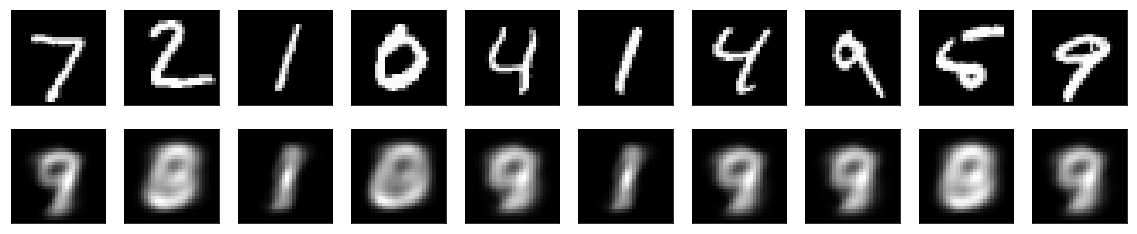

0.2355841


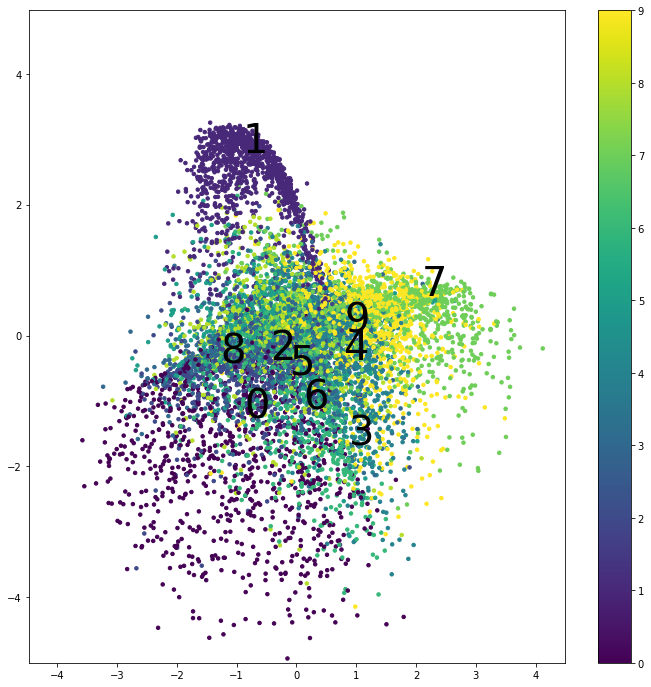

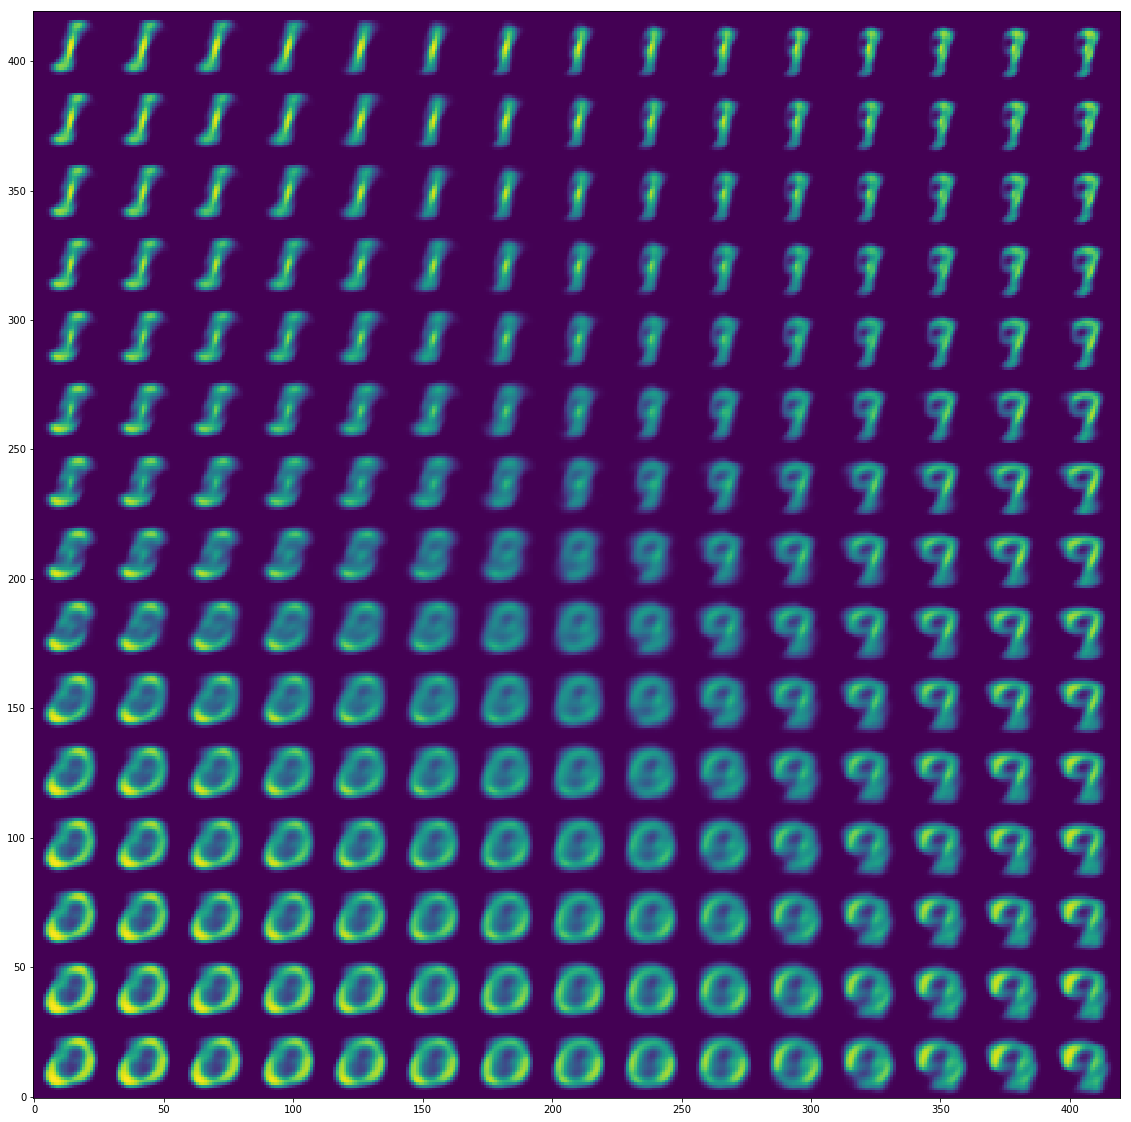



Test for saving:


Test for loading:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
batch_normalization_2 (Batch (None, 8

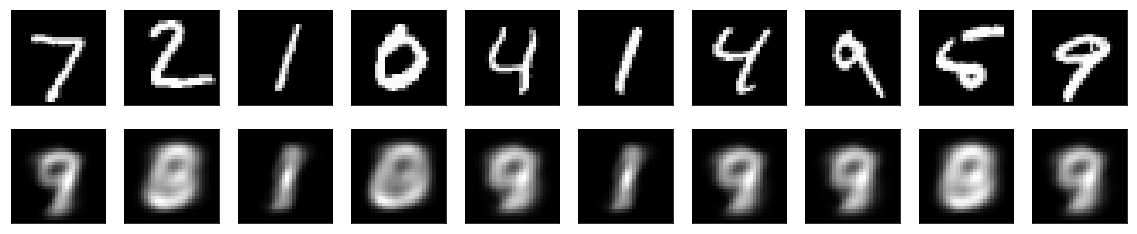

0.2355841


Test for specificdecode:
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 87us/step - loss: 0.6509 - binary_accuracy: 0.6302 - val_loss: 0.6261 - val_binary_accuracy: 0.8027

Epoch 00001: val_loss improved from inf to 0.62613, saving model to ../model/temp//AutoEncoder1540865895.2402823.hdf5
Epoch 2/5
60000/60000 [==============================] - 1s 20us/step - loss: 0.5356 - binary_accuracy: 0.7790 - val_loss: 0.5272 - val_binary_accuracy: 0.8032

Epoch 00002: val_loss improved from 0.62613 to 0.52718, saving model to ../model/temp//AutoEncoder1540865895.2402823.hdf5
Epoch 3/5
60000/60000 [==============================] - 1s 20us/step - loss: 0.4316 - binary_accuracy: 0.7922 - val_loss: 0.4358 - val_binary_accuracy: 0.8020

Epoch 00003: val_loss improved from 0.52718 to 0.43577, saving model to ../model/temp//AutoEncoder1540865895.2402823.hdf5
Epoch 4/5
60000/60000 [==============================] - 1s 20us/ste

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 138us/step - loss: 0.4535 - val_loss: 0.3024

Epoch 00001: val_loss improved from inf to 0.30244, saving model to ../model/temp//AutoEncoder1540865920.787861.hdf5
Epoch 2/5
60000/60000 [==============================] - 3s 43us/step - loss: 0.2658 - val_loss: 0.2359

Epoch 00002: val_loss improved from 0.30244 to 0.23587, saving model to ../model/temp//AutoEncoder1540865920.787861.hdf5
Epoch 3/5
60000/60000 [==============================] - 3s 43us/step - loss: 0.2437 - val_loss: 0.2284

Epoch 00003: val_loss improved from 0.23587 to 0.22840, saving model to ../model/temp//AutoEncoder1540865920.787861.hdf5
Epoch 4/5
60000/60000 [==============================] - 3s 42us/step - loss: 0.2378 - val_loss: 0.2266

Epoch 00004: val_loss improved from 0.22840 to 0.22659, saving model to ../model/temp//AutoEncoder1540865920.787861.hdf5
Epoch 5/5
60000/60000 [==========================

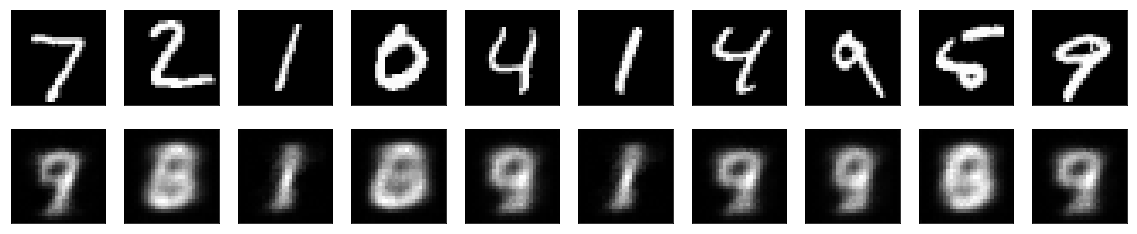

0.23563996


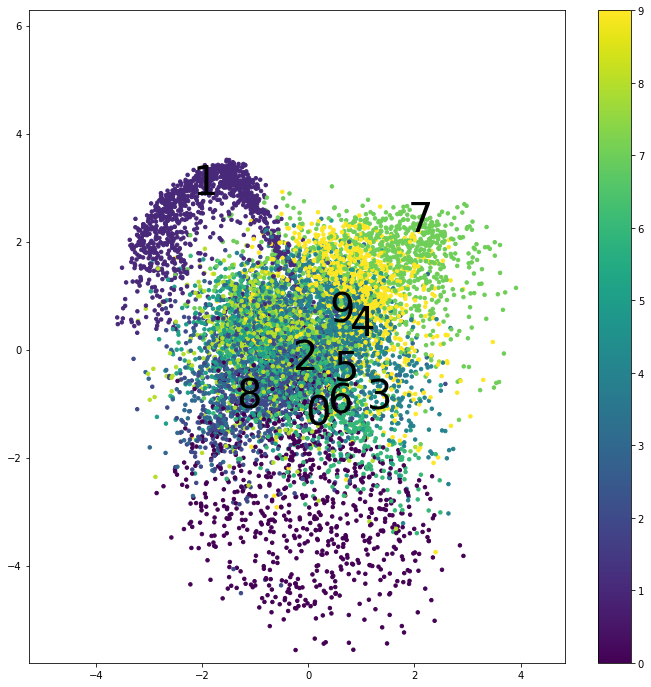

0.0038829579


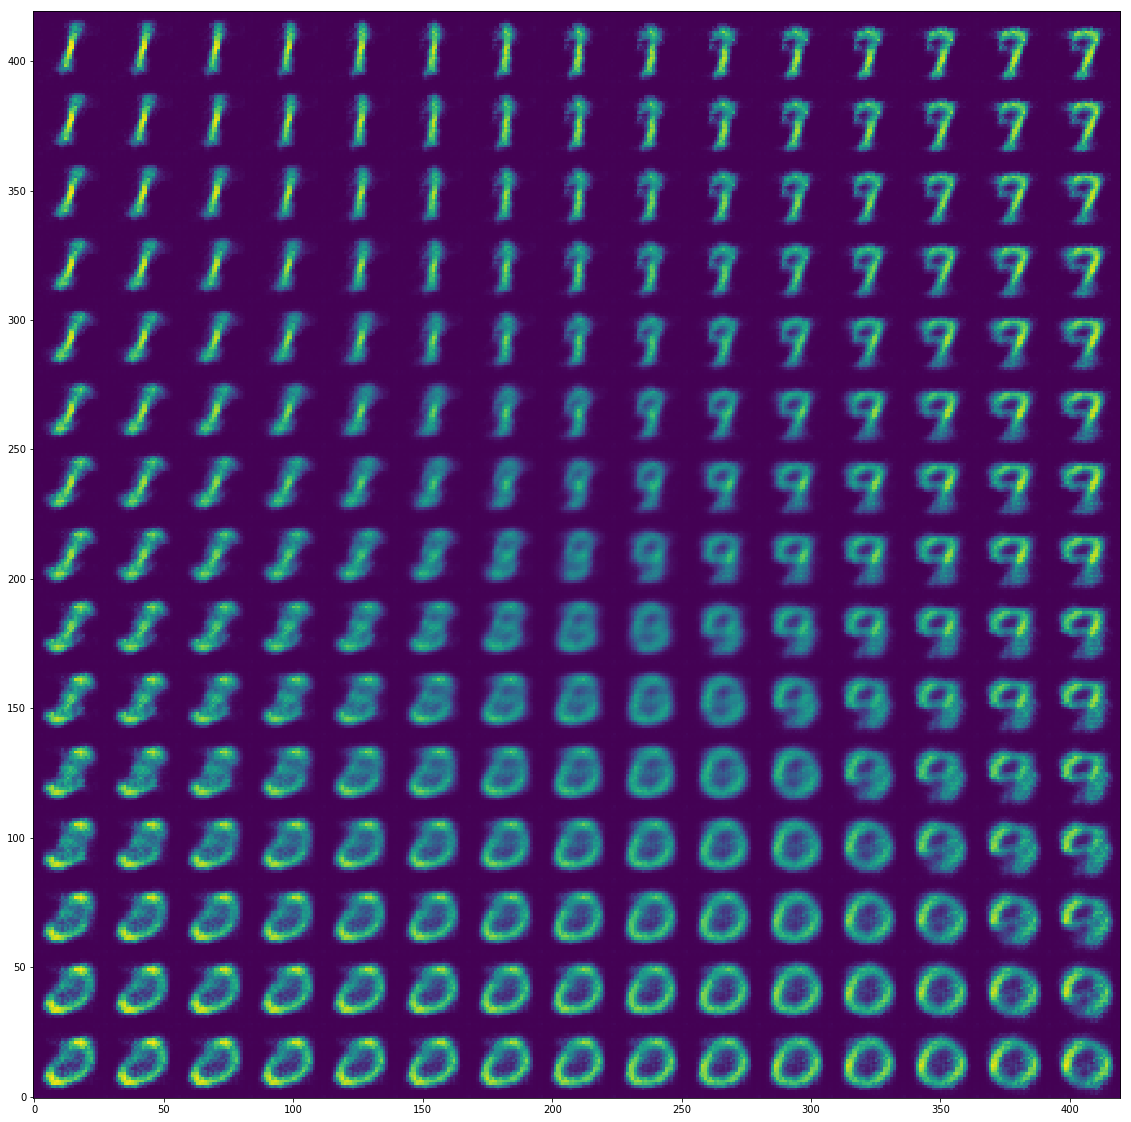



Test for saving:


Test for loading:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 4)         40        
_________________________________________________________________
batch_normalization_10 (Batc (None, 14, 14, 4)         16        
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          592       
_________________________________________________________________
batch_normalization_11 (Batc (None, 7, 7, 16)          64        
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 7

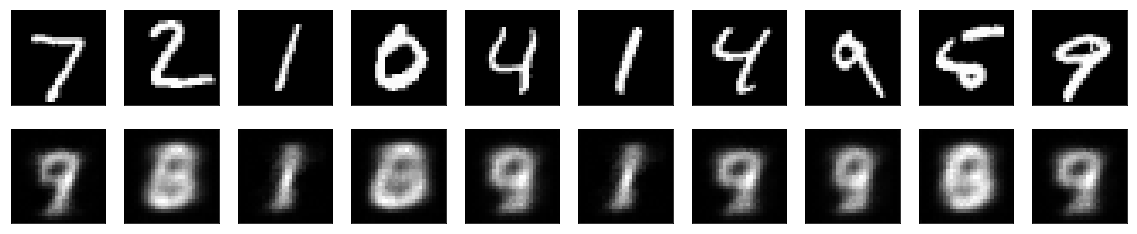

0.23563996


Test for specificdecode:
[1, 4, 16]
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 9s 148us/step - loss: 0.4405 - binary_accuracy: 0.7297 - val_loss: 0.3154 - val_binary_accuracy: 0.7425

Epoch 00001: val_loss improved from inf to 0.31539, saving model to ../model/temp//AutoEncoder1540865991.4443464.hdf5
Epoch 2/5
60000/60000 [==============================] - 2s 41us/step - loss: 0.2770 - binary_accuracy: 0.7948 - val_loss: 0.2605 - val_binary_accuracy: 0.7839

Epoch 00002: val_loss improved from 0.31539 to 0.26053, saving model to ../model/temp//AutoEncoder1540865991.4443464.hdf5
Epoch 3/5
60000/60000 [==============================] - 2s 42us/step - loss: 0.2633 - binary_accuracy: 0.7997 - val_loss: 0.2523 - val_binary_accuracy: 0.7906

Epoch 00003: val_loss improved from 0.26053 to 0.25234, saving model to ../model/temp//AutoEncoder1540865991.4443464.hdf5
Epoch 4/5
60000/60000 [==============================] 

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 9s 147us/step - loss: 0.5646 - val_loss: 0.4713

Epoch 00001: val_loss improved from inf to 0.47130, saving model to ../model/temp//AutoEncoder1540866031.930579.hdf5
Epoch 2/10
60000/60000 [==============================] - 2s 38us/step - loss: 0.3320 - val_loss: 0.3074

Epoch 00002: val_loss improved from 0.47130 to 0.30736, saving model to ../model/temp//AutoEncoder1540866031.930579.hdf5
Epoch 3/10
60000/60000 [==============================] - 2s 37us/step - loss: 0.2845 - val_loss: 0.2748

Epoch 00003: val_loss improved from 0.30736 to 0.27478, saving model to ../model/temp//AutoEncoder1540866031.930579.hdf5
Epoch 4/10
60000/60000 [==============================] - 2s 37us/step - loss: 0.2701 - val_loss: 0.2606

Epoch 00004: val_loss improved from 0.27478 to 0.26057, saving model to ../model/temp//AutoEncoder1540866031.930579.hdf5
Epoch 5/10
60000/60000 [=====================

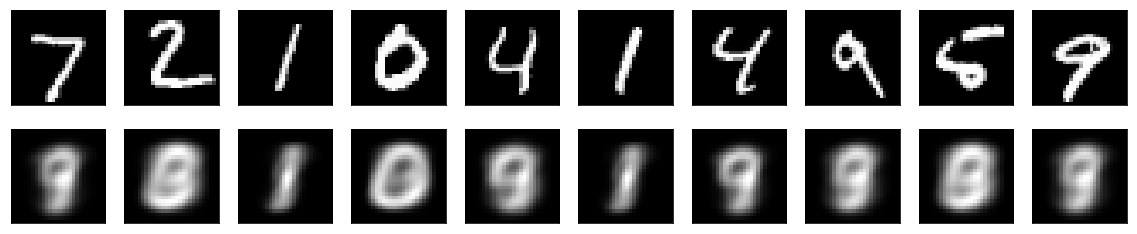

0.2420186


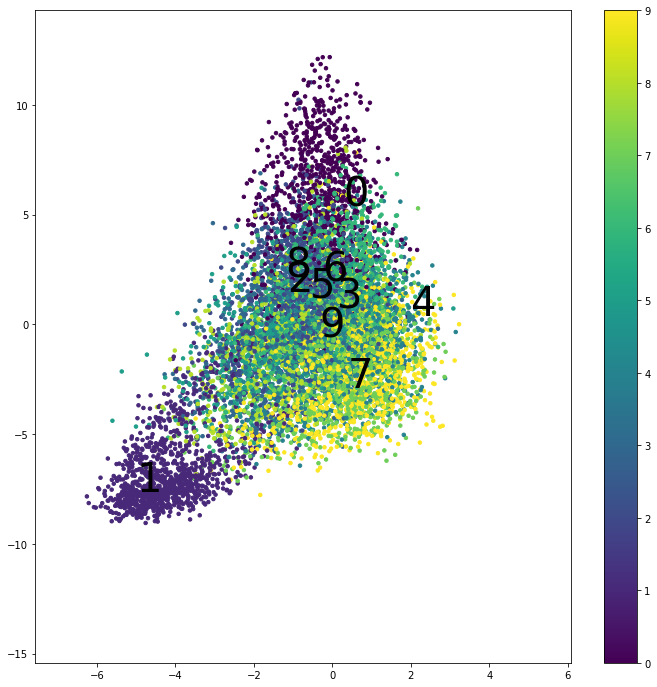

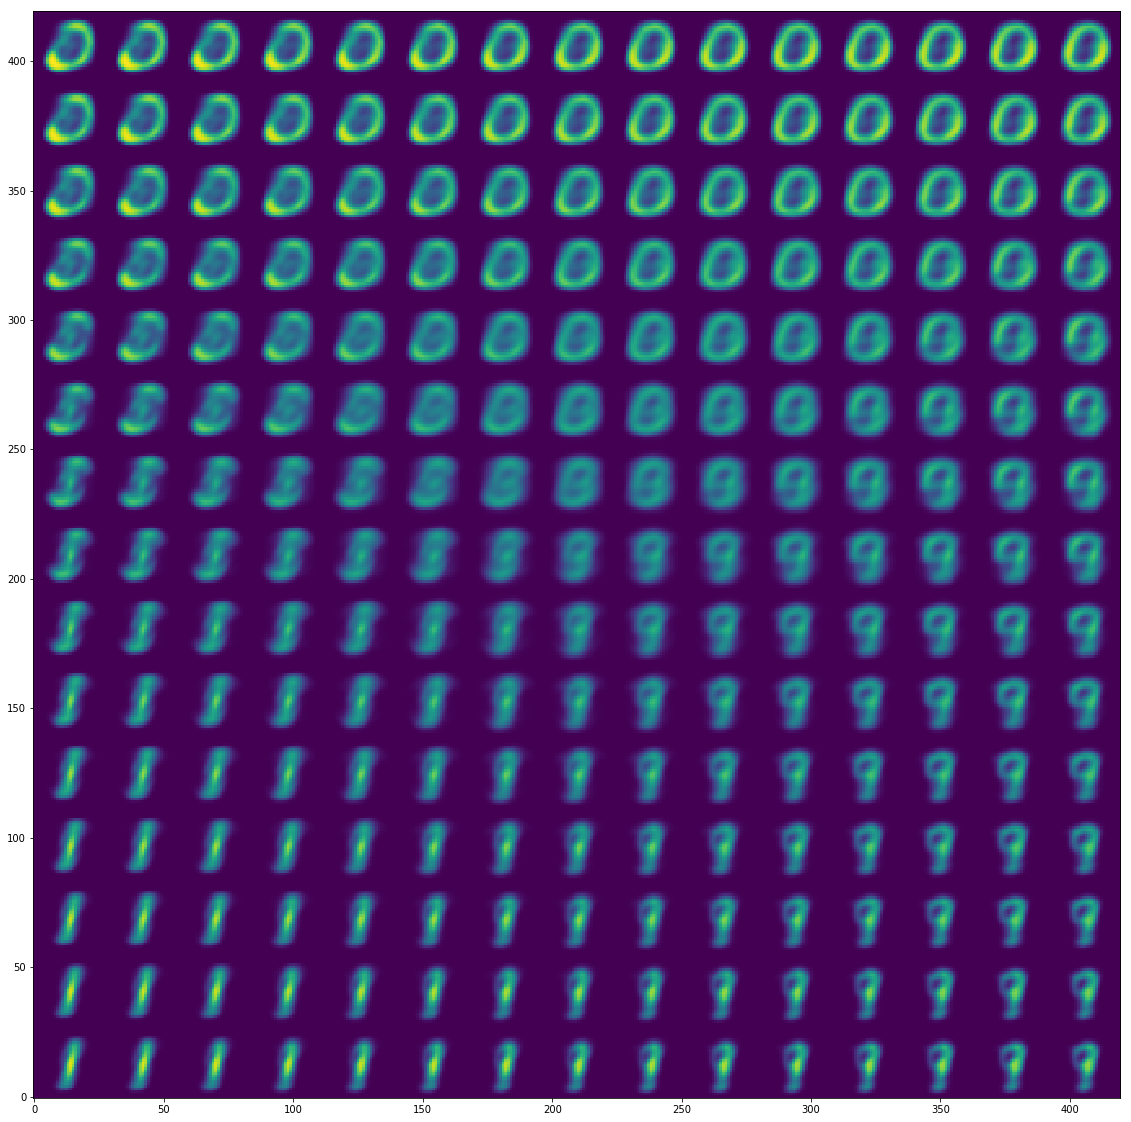



Test for saving:


Test for loading:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 32)           25120       input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 32)           128         dense_22[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_24 (LeakyReLU)      (None, 32)           0           batch_normalization_24[0][0]     
______________________________________________________________________

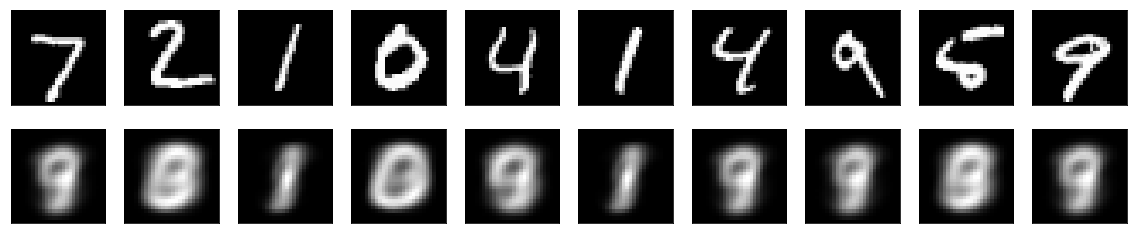

0.24196005


Test for ConvVAE:
Test for init:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 14, 14, 4)    40          input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 14, 14, 4)    16          conv2d_5[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_28 (LeakyReLU)      (None, 14, 14, 4)    0           batch_normalization_28[0][0]     
_______________________________________________________________

60000/60000 [==============================] - 3s 55us/step - loss: 0.2399 - val_loss: 0.2572

Epoch 00008: val_loss improved from 0.26040 to 0.25722, saving model to ../model/temp//AutoEncoder1540866132.5523076.hdf5
Epoch 9/10
60000/60000 [==============================] - 3s 54us/step - loss: 0.2385 - val_loss: 0.2539

Epoch 00009: val_loss improved from 0.25722 to 0.25390, saving model to ../model/temp//AutoEncoder1540866132.5523076.hdf5
Epoch 10/10
60000/60000 [==============================] - 3s 54us/step - loss: 0.2375 - val_loss: 0.2491

Epoch 00010: val_loss improved from 0.25390 to 0.24909, saving model to ../model/temp//AutoEncoder1540866132.5523076.hdf5


Test for prediction:


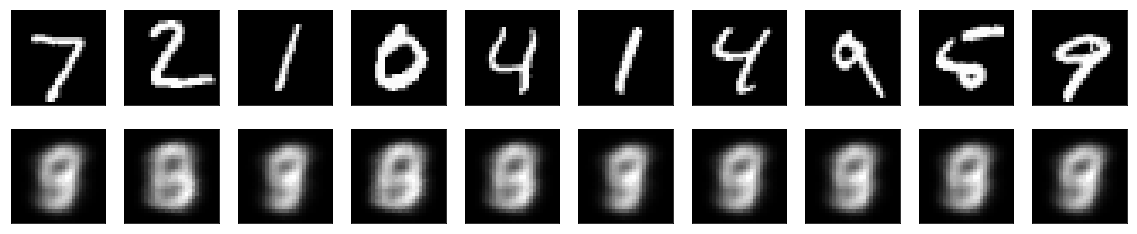

0.2513828


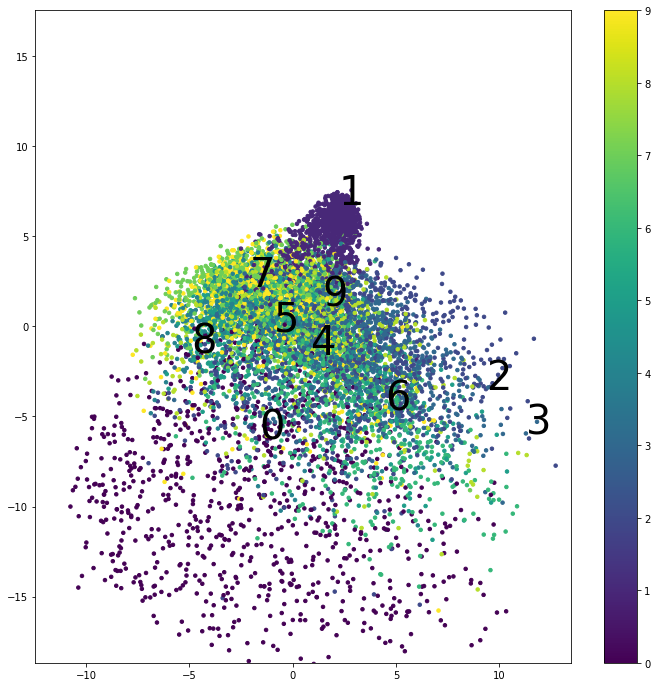

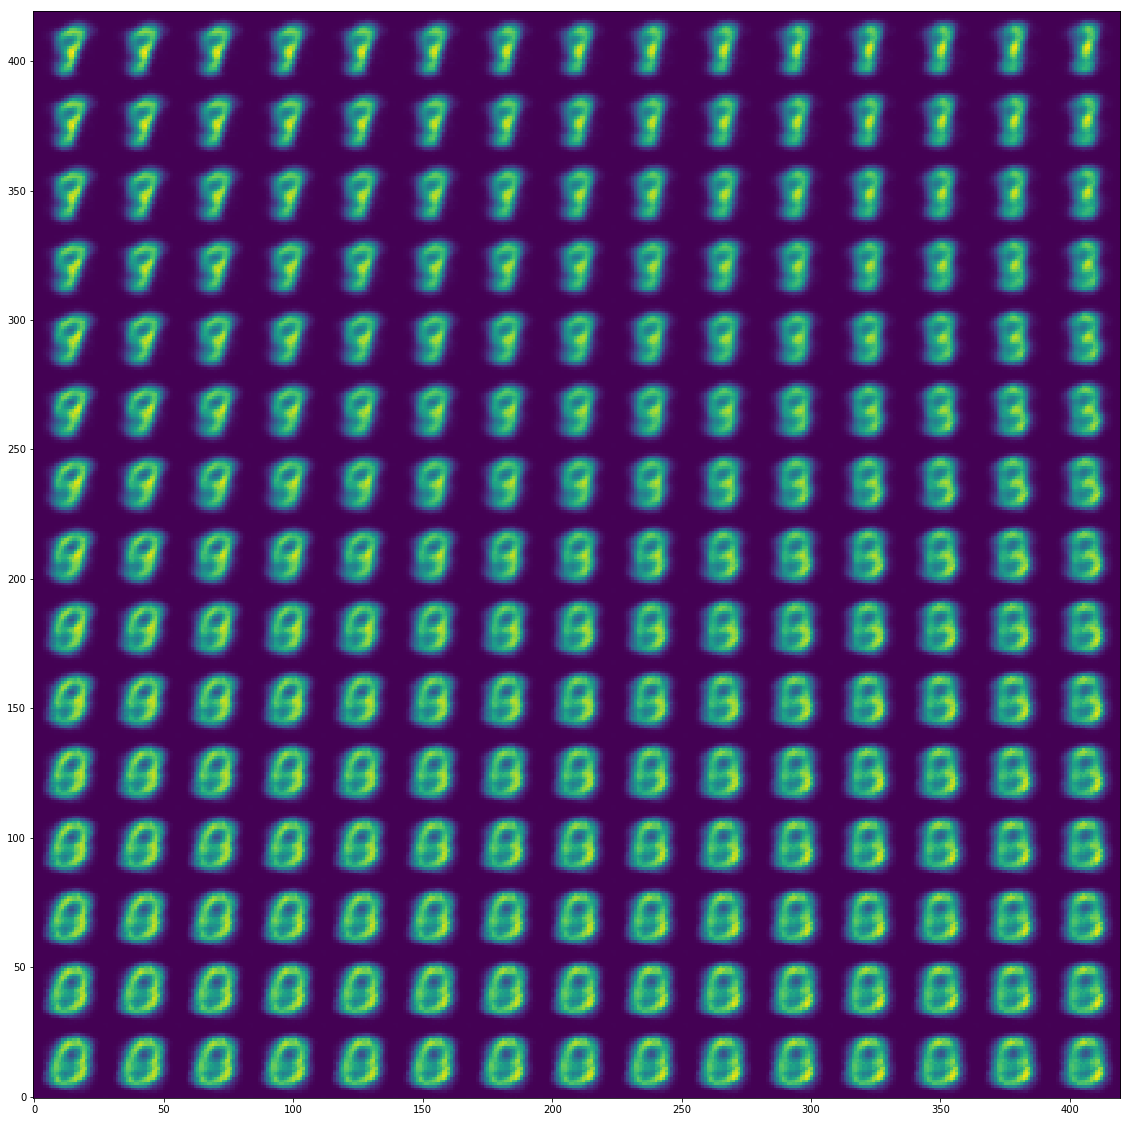



Test for saving:


Test for loading:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 14, 14, 4)    40          input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 14, 14, 4)    16          conv2d_5[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_28 (LeakyReLU)      (None, 14, 14, 4)    0           batch_normalization_28[0][0]     
______________________________________________________________________

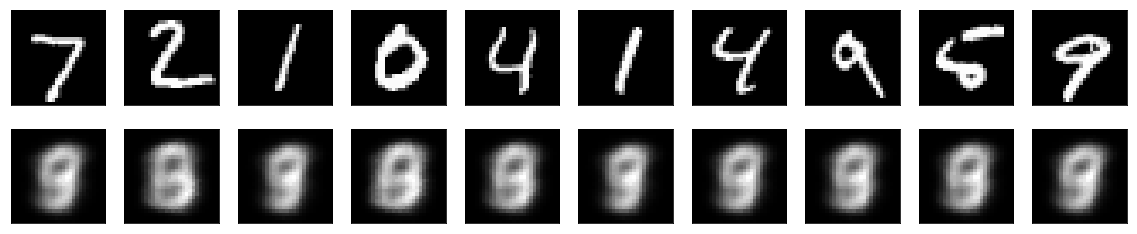

0.2513851




In [6]:
if __name__ == "__main__":
    testAE = TestAE()
    testAE.test_init()
    testAE.test_fit()
#     testAE.test_fit_check_best()
    testAE.test_fit_check_verbose()
    testAE.test_prediction()
    testAE.test_save()
    testAE.test_load()
    testAE.test_specific_decode()
     
    testConvAE = TestConvAE()
    testConvAE.test_init()
    testConvAE.test_fit()
#     testConvAE.test_fit_check_best()
    testConvAE.test_prediction()
    testConvAE.test_save()
    testConvAE.test_load()
    testConvAE.test_specific_decode()
    
    testVAE = TestVAE()
    testVAE.test_init()
    testVAE.test_fit()
#     testVAE.test_fit_check_best()
    testVAE.test_prediction()
    testVAE.test_save()
    testVAE.test_load()

    testConv = TestConvVAE()
    testConv.test_init()
    testConv.test_fit()
    testConv.test_prediction()
    testConv.test_save()
    testConv.test_load()